In [1]:
%load_ext autoreload
%autoreload 2

import gsum as gm
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from nuclear_matter.stats_utils import *
from nuclear_matter.matter import *
from nuclear_matter import setup_rc_params
from nuclear_matter import InputData
import seaborn as sns
import time

%matplotlib inline

In [2]:
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['figure.dpi'] = 150
# mpl.rcParams['font.family'] = 'serif'
# mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, format='pdf')
setup_rc_params()

# Analysis of Nuclear Matter Results (Refactored)

A much cleaner version of the other notebook. It can be easily extended.

First, import the data

In [3]:
# Lambda = 450
Lambda = 500

high_density = False
if high_density:
    filename = '../data/all_matter_data_high_density.csv'
else:
    filename = '../data/all_matter_data.csv'
    
data = InputData(filename, Lambda, high_density)

# if high_density:
#     df = pd.read_csv('../data/all_matter_data_high_density.csv')
# else:
#     df = pd.read_csv('../data/all_matter_data.csv')
#     # Convert differences to total prediction at each MBPT order
#     mbpt_orders = ['Kin', 'MBPT_HF', 'MBPT_2', 'MBPT_3', 'MBPT_4']
#     df[mbpt_orders] = df[mbpt_orders].apply(np.cumsum, axis=1)
#     # 'total' is now unnecessary. Remove it.
#     df.pop('total');

Now define all of the parameters of the analysis.

In [4]:
orders = np.array([0, 2, 3, 4])
excluded = np.array([0, 1])

body2 = 'NN-only'
body23 = 'NN+3N'
body3 = '3N'
body23_appended = 'Appended'

pure_neutron = 'pure'
sym_nuclear = 'sym'
# avg_momentum = 'avg'
s2_energy = 's2'

train = slice(None, None, 4)
valid = slice(2, None, 4)


excluded_2bf = np.array([0, 1])
# excluded_2bf = np.array([1])
excluded_3bf = np.array([0, 1, 2])

savefigs = False

Lb = 600

breakdown_min = 300
breakdown_max = 1000
breakdown_num = 100
Lb_vals = np.linspace(breakdown_min, breakdown_max, breakdown_num)
Lb_logprior_vals = Lb_logprior(Lb_vals)

ls_min = 0.1
ls_max = 1.5
ls_num = 50
ls_vals = np.linspace(ls_min, ls_max, ls_num)
# ls_min = ls_max = ls_num = ls_vals = None


# The Gaussian process parameters
nugget = 1e-5

kernel = RBF(length_scale=1, length_scale_bounds=(5e-2, 4)) + \
    WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
# kernel1 = RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + \
#     WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
kernel_theta = kernel.theta
ref_2bf = 16

hyperparams = dict(
    center=0,
    disp=0,
    df=0,
    scale=1,
)

# optimizer = None

In [5]:
kf_n = data.kf_n
Kf_n = data.Kf_n
kf_s = data.kf_s
Kf_s = data.Kf_s
kf_d = data.kf_avg
Kf_d = data.Kf_avg

density = data.density

ref_2bf = data.ref_2bf
ref_n_3bf = data.ref_n_3bf
ref_s_3bf = data.ref_s_3bf
ref_d_3bf = data.ref_avg_3bf

y_s_2_plus_3bf = data.y_s_2_plus_3bf
y_n_2_plus_3bf = data.y_n_2_plus_3bf
y_d_2_plus_3bf = data.y_d_2_plus_3bf

y_s_2bf = data.y_s_2bf
y_n_2bf = data.y_n_2bf
y_d_2bf = data.y_d_2bf

y_s_3bf = data.y_s_3bf
y_n_3bf = data.y_n_3bf
y_d_3bf = data.y_d_3bf

fit_n2lo = data.fit_n2lo
fit_n3lo = data.fit_n3lo

In [6]:
# orders = np.array([0, 2, 3, 4])
# # body = 'NN-only'
# # body = 'NN+3N'
# Lambda = 450
# fits = {450: [1, 7], 500: [4, 10]}
# train1 = slice(None, None, 5)
# valid1 = slice(2, None, 5)
# # valid1 = np.array([i % 5 != 0 for i in range(len())])
# [fit_n2lo, fit_n3lo] = fits[Lambda]

# excluded = np.array([0, 1])

# savefigs = False

# Lb = 600

# breakdown_min = 300
# breakdown_max = 1000
# breakdown_num = 100
# Lb_vals = np.linspace(breakdown_min, breakdown_max, breakdown_num)
# Lb_logprior_vals = Lb_logprior(Lb_vals)

# ls_min = 0.1
# ls_max = 1.5
# ls_num = 50
# ls_vals = np.linspace(ls_min, ls_max, ls_num)
# # ls_min = ls_max = ls_num = ls_vals = None

# nugget = 1e-8

# kernel1 = RBF(length_scale=1, length_scale_bounds=(5e-2, 4)) + \
#     WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
# # kernel1 = RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + \
# #     WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
# kernel1_theta = kernel1.theta
# ref1 = 16

# hyperparams = dict(
#     center=0,
#     disp=0,
# #     df=1,
# #     scale=1
#     sd=2
# )


# mask_fit = np.isin(df['fit'], fits[Lambda]) | np.isnan(df['fit'])

# mask1 = \
# #     (df['Body'] == body) & \
#     mask_fit & \
#     (df['Lambda'] == Lambda)


# # df_fit = df[mask_fit]
# df_n = df[mask1 & (df['x'] == 0)]
# df_s = df[mask1 & (df['x'] == 0.5)]

# kf_n = df_n[(df_n['OrderEFT'] == 'LO') & (df_n['Body'] == 'NN-only')]['kf'].values
# kf_s = df_s[(df_s['OrderEFT'] == 'LO') & (df_s['Body'] == 'NN-only')]['kf'].values
# density = df_n[(df_n['OrderEFT'] == 'LO') & (df_n['Body'] == 'NN-only')]['n'].values
# kf_d = kf_n.copy()

# # valid1 = np.arange(len(kf_n)) % 5 != 0

# Kf_n = kf_n[:, None]
# Kf_s = kf_s[:, None]
# Kf_d = kf_d[:, None]

# kf_s_dense = np.linspace(kf_s.min(), kf_s.max(), 100)
# Kf_s_dense = kf_s_dense[:, None]

# if not high_density:
#     kf_n_dense = np.linspace(kf_n.min(), kf_n.max(), 100)
#     Kf_n_dense = kf_n_dense[:, None]

#     kf_d_dense = np.linspace(kf_d.min(), kf_d.max(), 100)
#     Kf_d_dense = kf_d_dense[:, None]

#     y1_n = np.array([df_n[df_n['OrderEFT'] == order]['MBPT_4'].values for order in df_n['OrderEFT'].unique()]).T
#     y1_s = np.array([df_s[df_s['OrderEFT'] == order]['MBPT_4'].values for order in df_s['OrderEFT'].unique()]).T
#     y1_d = y1_n - y1_s
# else:
#     y1_s = np.array([df_s[df_s['OrderEFT'] == order]['MBPT_4'].values for order in df_s['OrderEFT'].unique()]).T

In [7]:
def ref_cubic_3bf(X):
    """Compute 16 kf^3 for any kf prescription"""
    return 16 * X.ravel() ** 3

def ref_linear_3bf(X):
    """Compute 16 kf^3 for any kf prescription"""
    return 16 * X.ravel()


ref_3bf_func = ref_linear_3bf

These analysis objects will contain all the observable-specific info and know how to make various plots.
The plots will save with informative image names and avoid a cluttered namespace. As we start varying more parameters, we should make sure that each important variable is reflected in the figure names, so that we don't overwrite images.

In [8]:
y_s_2bf.shape

(17, 4)

In [9]:
if high_density:
    n_body = body23
    analysis_s = MatterConvergenceAnalysis(
        X=Kf_s, y2=y_s_2bf, y3=y_s_2_plus_3bf, orders=orders, train=train, valid=valid,
        ref2=ref_2bf, ref3=ref_3bf_func, ratio='kf', density=density,
        kernel=kernel, system='symmetric', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
        body=n_body, savefigs=savefigs, excluded=excluded, **hyperparams
    )
else:
    n_body = body23_appended
    
    analysis_s = MatterConvergenceAnalysis(
        X=Kf_s, y2=y_s_2bf, y3=y_s_2_plus_3bf, orders=orders, train=train, valid=valid,
        ref2=ref_2bf, ref3=ref_3bf_func,  ratio='kf', density=density,
        kernel=kernel, system='symmetric', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
        body=n_body, savefigs=savefigs, excluded=excluded, **hyperparams
    )
    analysis_n = MatterConvergenceAnalysis(
        X=Kf_n, y2=y_n_2bf, y3=y_n_2_plus_3bf, orders=orders, train=train, valid=valid,
        ref2=ref_2bf, ref3=ref_3bf_func, ratio='kf', density=density,
        kernel=kernel, system='neutron', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
        body=n_body, savefigs=savefigs, excluded=excluded, **hyperparams
    )
    analysis_d = MatterConvergenceAnalysis(
        X=Kf_d, y2=y_d_2bf, y3=y_d_2_plus_3bf, orders=orders, train=train, valid=valid,
        ref2=ref_2bf, ref3=ref_3bf_func, ratio='kf', density=density,
        kernel=kernel, system='difference', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
        body=n_body, savefigs=savefigs, excluded=excluded, **hyperparams
    )

Appending 2bf and 3bf predictions...
Reseting orders to be [0 2 3 3 4 4]
Appending 2bf and 3bf predictions...
Reseting orders to be [0 2 3 3 4 4]
Appending 2bf and 3bf predictions...
Reseting orders to be [0 2 3 3 4 4]


Can take a while if a large breakdown/ls grid is used

In [10]:
if n_body == body23_appended:
    max_idxs = [3, 5]
    max_idx_labels = [2, 3]
else:
    max_idxs = [2, 3]
    max_idx_labels = None

t_start = time.time()
if high_density:
    analysis_s.setup_posteriors(
        breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
        ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
        max_idx=max_idxs, max_idx_labels=max_idx_labels, logprior=None
    )
else:
    analysis_s.setup_posteriors(
        breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
        ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
        max_idx=max_idxs, max_idx_labels=max_idx_labels, logprior=None
    )
    analysis_n.setup_posteriors(
        breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
        ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
        max_idx=max_idxs, max_idx_labels=max_idx_labels, logprior=None
    )
    analysis_d.setup_posteriors(
        breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
        ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
        max_idx=max_idxs, max_idx_labels=max_idx_labels, logprior=None
    );
print(time.time() - t_start)

26.769142150878906


Create a DataFrame that holds the $\Lambda_b$ pdf for all observables put together. Assume they are independent, so they multiply. Also, we assumed a constant prior above, so we don't need to worry about accidentally overcounting it.

In [11]:
df_Lb_pdf_all = analysis_n.df_breakdown.copy()
df_Lb_pdf_all['pdf'] = analysis_n.df_breakdown['pdf'] * analysis_s.df_breakdown['pdf'] * analysis_d.df_breakdown['pdf']
df_Lb_pdf_all['system'] = 'All'

In [12]:
def dict_to_str(d):
    s = ''
    for key, value in d.items():
        s += f'{key}-{value}_'
    s = s.replace('.', 'p')
    return s[:-1]

Create the plot of all their pdfs

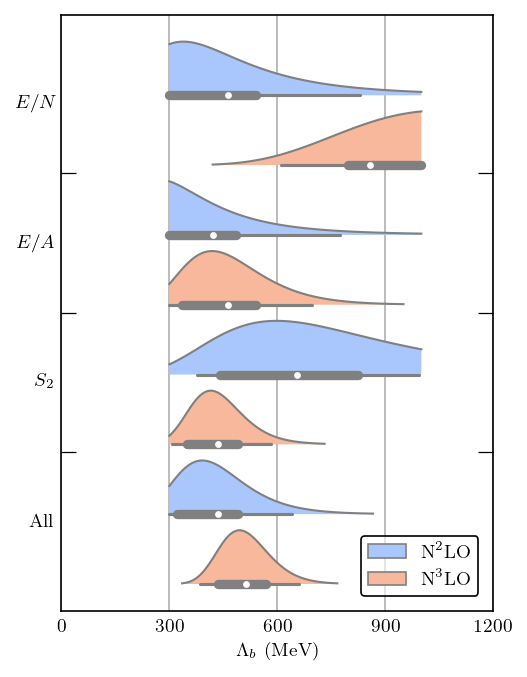

In [13]:
fig, ax = plt.subplots(figsize=(3.4, 4.4))
df_Lb_pdf = pd.concat([analysis_n.df_breakdown, analysis_s.df_breakdown, analysis_d.df_breakdown, df_Lb_pdf_all])
ax = pdfplot(
    x=r'$\Lambda_b$ (MeV)', y='system', pdf='pdf', data=df_Lb_pdf, hue='Order',
    order=[r'$E/N$', r'$E/A$', r'$S_2$', 'All'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1,
        palette="coolwarm", saturation=1., ax=ax, margin=0.3,
)
ax.set_xlim(0, 1200)
ax.set_xticks([0, 300, 600, 900, 1200])
ax.grid(axis='x')
ax.set_axisbelow(True)
if savefigs:
    fig.savefig(
        analysis_n.figure_name(
            'Lb_pdfs_', breakdown=(breakdown_min, breakdown_max, breakdown_num), include_system=False,
            ls=(ls_min, ls_max, ls_num),
        )
    )

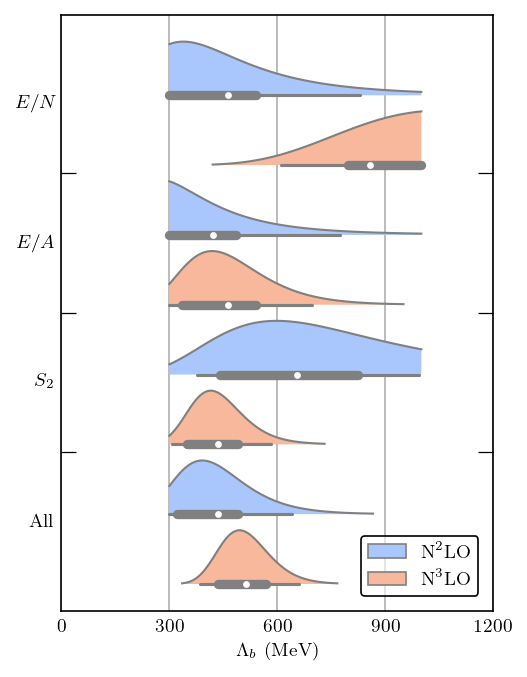

In [14]:
fig, ax = plt.subplots(figsize=(3.4, 4.4))
df_Lb_pdf = pd.concat([analysis_n.df_breakdown, analysis_s.df_breakdown, analysis_d.df_breakdown, df_Lb_pdf_all])
ax = pdfplot(
    x=r'$\Lambda_b$ (MeV)', y='system', pdf='pdf', data=df_Lb_pdf, hue='Order',
    order=[r'$E/N$', r'$E/A$', r'$S_2$', 'All'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1,
        palette="coolwarm", saturation=1., ax=ax, margin=0.3,
)
ax.set_xlim(0, 1200)
ax.set_xticks([0, 300, 600, 900, 1200])
ax.grid(axis='x')
ax.set_axisbelow(True)
if savefigs:
    fig.savefig(
        analysis_n.figure_name(
            'Lb_pdfs_', breakdown=(breakdown_min, breakdown_max, breakdown_num), include_system=False,
            ls=(ls_min, ls_max, ls_num),
        )
    )

In [15]:
lb_max_mask = \
    (df_Lb_pdf['Body'] == 'Appended') & \
    (df_Lb_pdf['system'] == 'All') & \
    (df_Lb_pdf['Order'] == 'N$^3$LO')
lb_max_idx = df_Lb_pdf[lb_max_mask]['pdf'].idxmax()
lb_map = df_Lb_pdf[lb_max_mask].loc[lb_max_idx]['$\Lambda_b$ (MeV)']
lb_map

497.979797979798

Now one for the marginal length scale pdfs. A common length scale for all observables probably isn't necessary, so don't compute an "All" pdf.

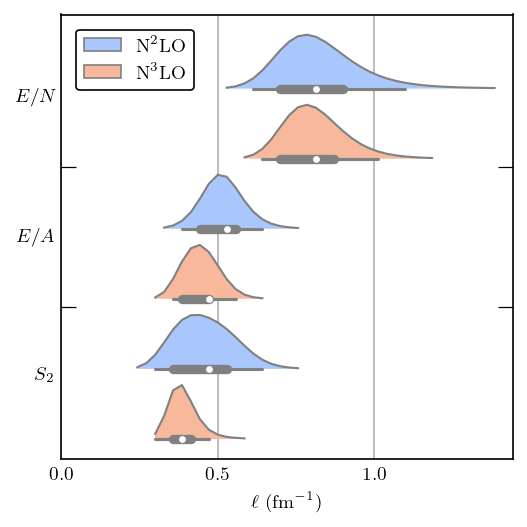

In [16]:
df_ls_pdf = pd.concat([analysis_n.df_ls, analysis_s.df_ls, analysis_d.df_ls])
ax = pdfplot(
    x=r'$\ell$ (fm$^{-1}$)', y='system', pdf='pdf', data=df_ls_pdf, hue='Order',
    order=[r'$E/N$', r'$E/A$', r'$S_2$'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1.,
        palette="coolwarm", saturation=1., ax=None, margin=0.3,
)
ax.set_xticks([0, 0.5, 1.]);
ax.grid(axis='x');
ax.set_axisbelow(True)
if savefigs:
    fig.savefig(
        analysis_n.figure_name(
            'ls_pdfs_', breakdown=(breakdown_min, breakdown_max, breakdown_num), include_system=False,
            ls=(ls_min, ls_max, ls_num),
        )
    )

/Users/jordan.melendez/repos/nuclear-matter-convergence/nuclear_matter/stats_utils.py:145: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout(h_pad=0, w_pad=0)


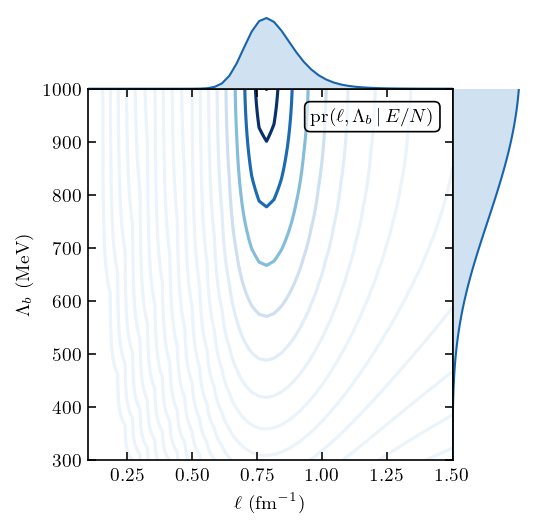

In [17]:
fig = analysis_n.plot_joint_breakdown_ls(max_idx=3)

/Users/jordan.melendez/repos/nuclear-matter-convergence/nuclear_matter/stats_utils.py:145: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout(h_pad=0, w_pad=0)


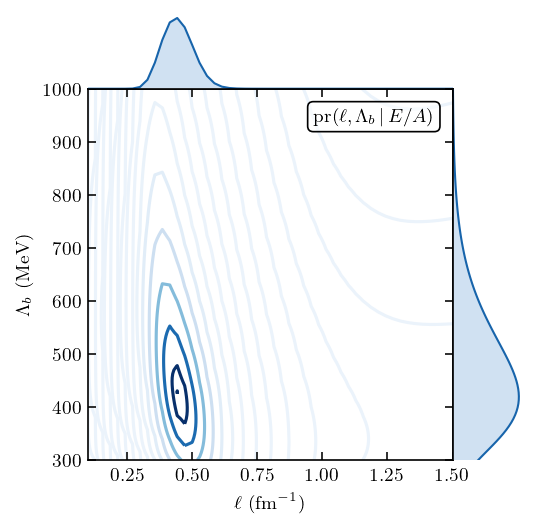

In [18]:
fig = analysis_s.plot_joint_breakdown_ls(max_idx=3)

/Users/jordan.melendez/repos/nuclear-matter-convergence/nuclear_matter/stats_utils.py:145: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout(h_pad=0, w_pad=0)


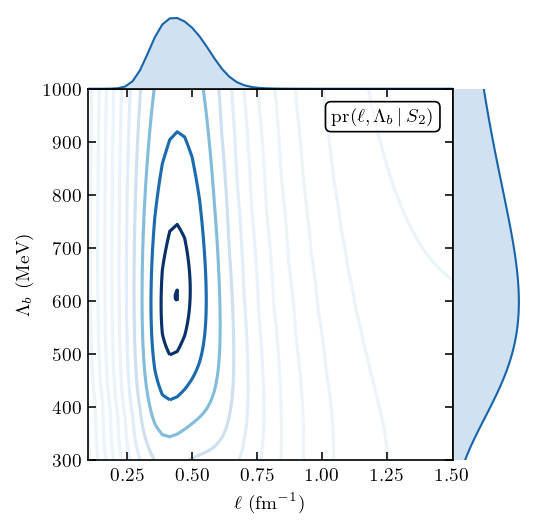

In [19]:
fig = analysis_d.plot_joint_breakdown_ls(max_idx=2)

RBF(length_scale=0.783) + WhiteKernel(noise_level=1e-05)
cbar mean: 0.7459405200690608


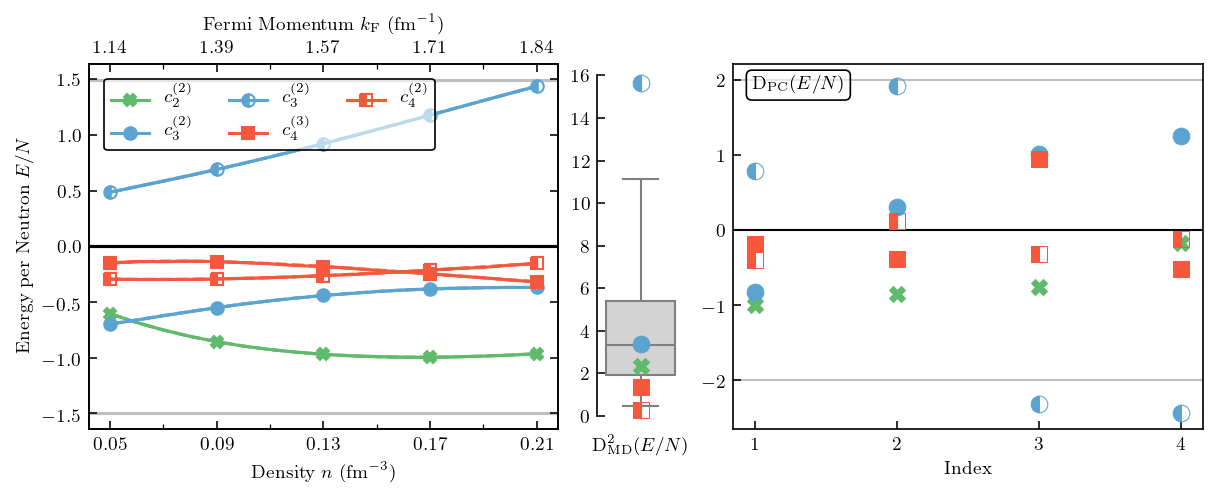

In [20]:
fig = analysis_n.plot_coeff_diagnostics(breakdown=Lb)

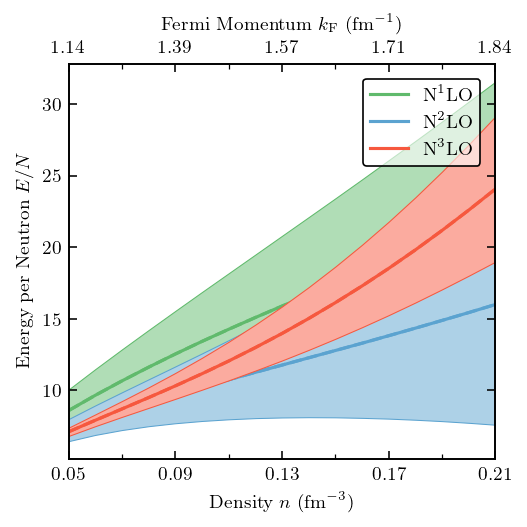

In [21]:
fig = analysis_n.plot_observables(breakdown=Lb, show_process=True)

Using breakdown = 1000.0 MeV
RBF(length_scale=0.783) + WhiteKernel(noise_level=1e-05)
cbar mean: 3.5772216424226913


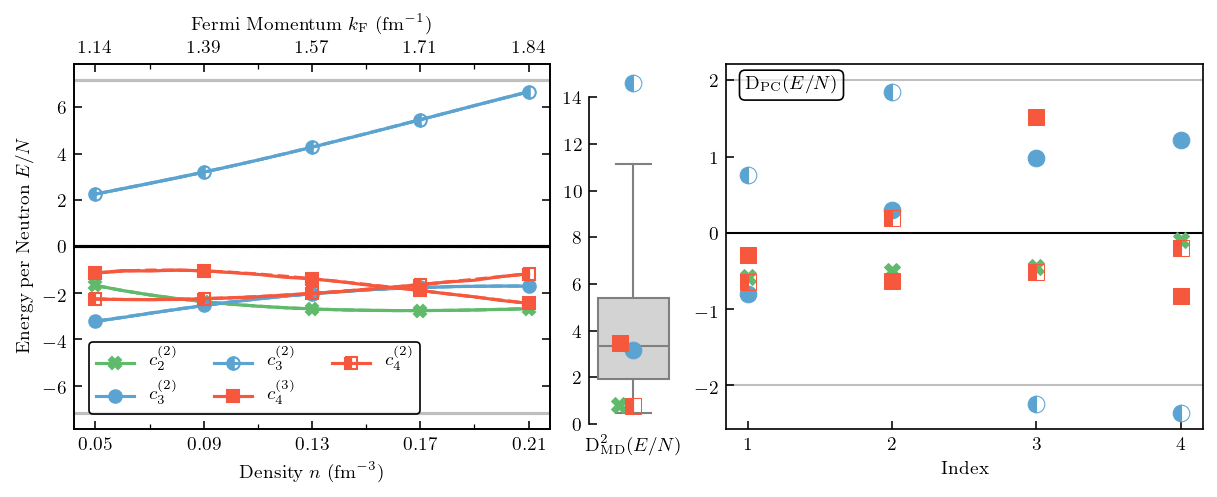

In [22]:
fig = analysis_n.plot_coeff_diagnostics(breakdown=None)

RBF(length_scale=0.783) + WhiteKernel(noise_level=1e-05)
cbar mean: 0.4321226364374663


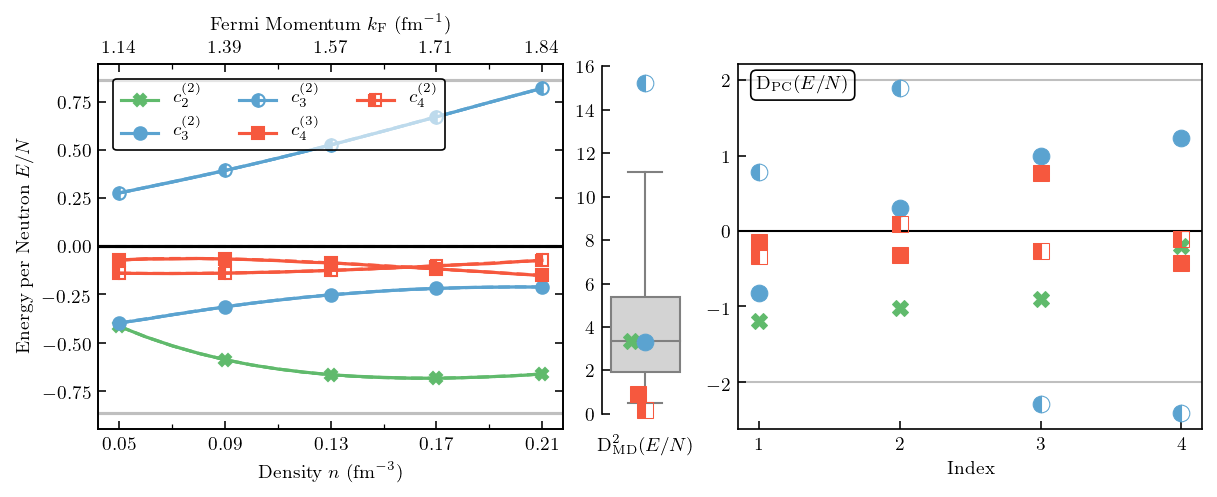

In [23]:
fig = analysis_n.plot_coeff_diagnostics(breakdown=lb_map)

Using breakdown = 1000.0 MeV


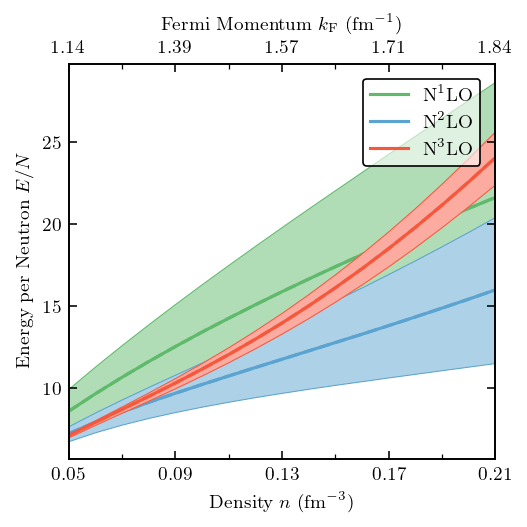

In [24]:
fig = analysis_n.plot_observables(breakdown=None, show_process=True)

There's clearly some noise below, we should include it in the kernel. Discuss with Christian about the precision of his calculations.

RBF(length_scale=0.404) + WhiteKernel(noise_level=1e-05)
cbar mean: 2.4301311830372216


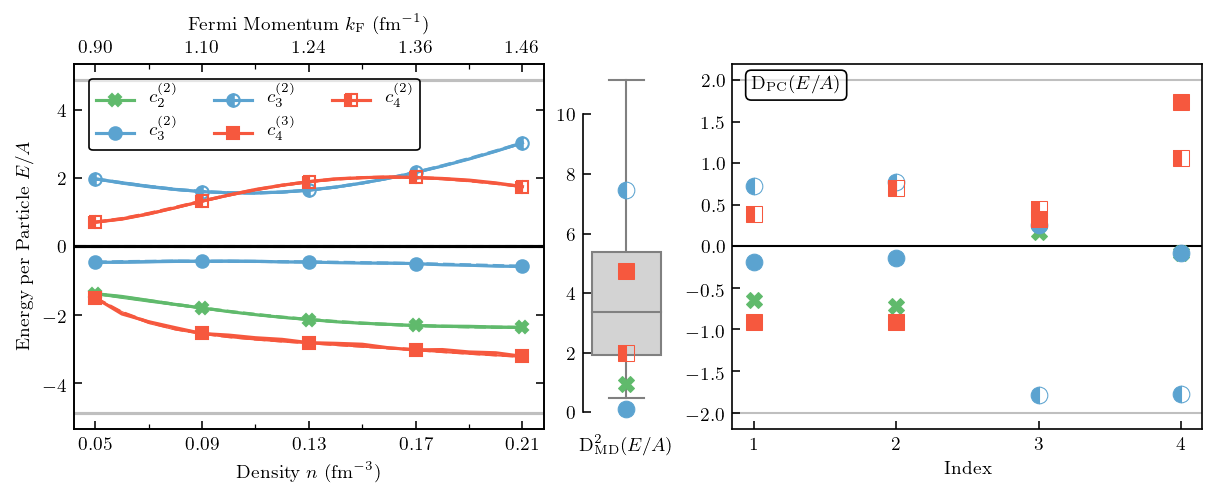

In [25]:
fig = analysis_s.plot_coeff_diagnostics(breakdown=Lb)

RBF(length_scale=0.428) + WhiteKernel(noise_level=1e-05)
cbar mean: 1.4313719518758505


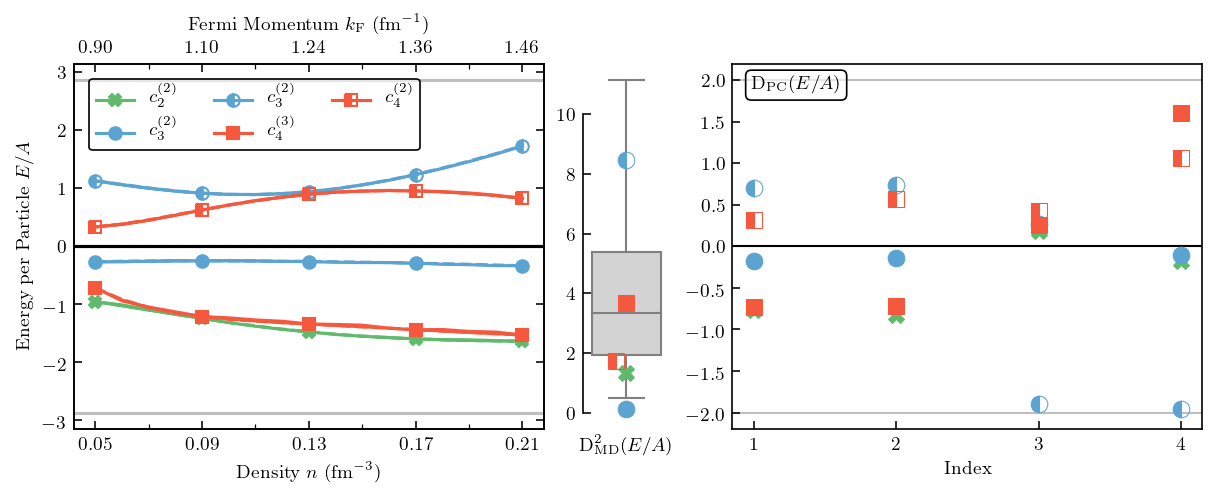

In [26]:
fig = analysis_s.plot_coeff_diagnostics(breakdown=lb_map)

Using breakdown = 427.27272727272725 MeV
RBF(length_scale=0.449) + WhiteKernel(noise_level=1e-05)
cbar mean: 0.9367327939682664


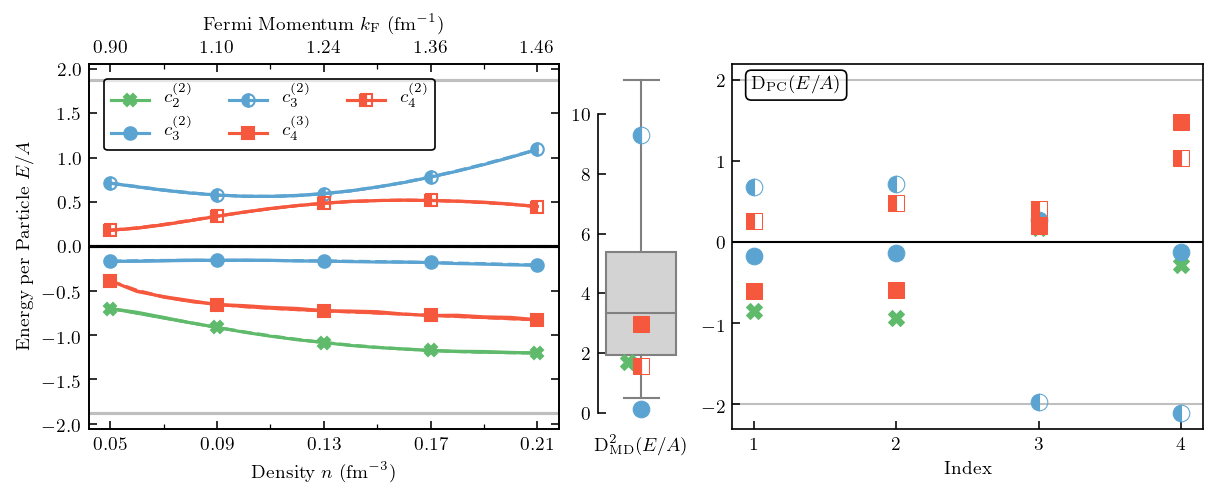

In [27]:
fig = analysis_s.plot_coeff_diagnostics(breakdown=None)

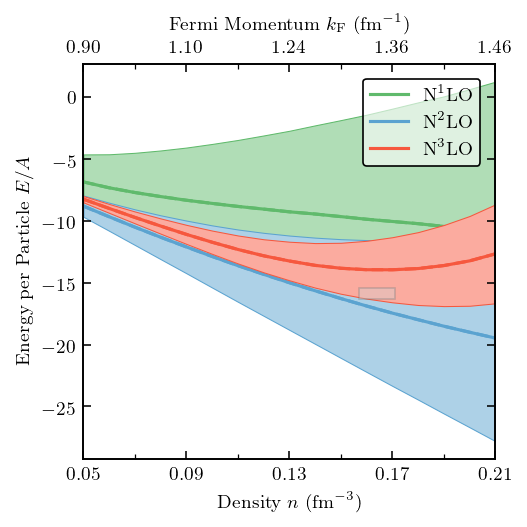

In [28]:
fig = analysis_s.plot_observables(breakdown=Lb, show_process=True)

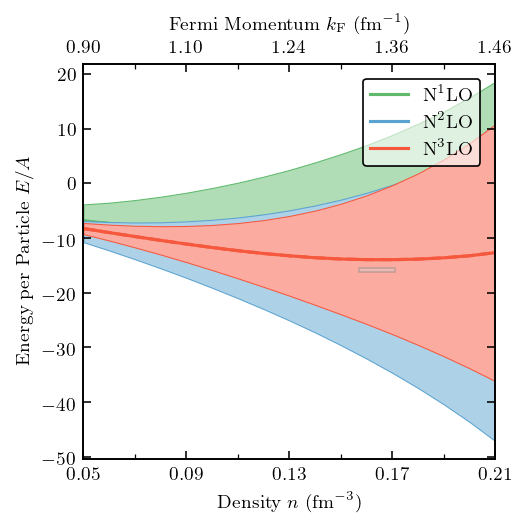

In [29]:
fig = analysis_s.plot_observables(breakdown=339, show_process=True)

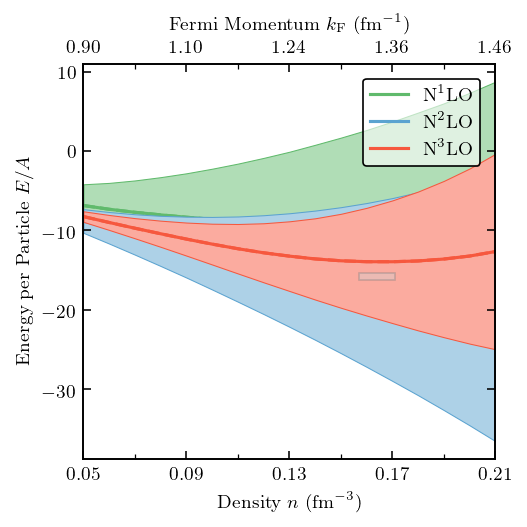

In [30]:
fig = analysis_s.plot_observables(breakdown=400, show_process=True)

In [31]:
np.squeeze(np.argwhere(np.arange(5) == 3))

array(3)

In [32]:
kf_s_dense = np.linspace(kf_s.min(), kf_s.max(), 200)
Kf_s_dense = kf_s_dense[:, None]
n_samples = 3000
# The points to fit the GP to (but hyperparameter training is still at "train")
sat_conditioned = slice(None, None, 2)

In [33]:
# fig, ax = plt.subplots(1, 1, figsize=(4, 3.4))

# np.random.seed(1)
# _, ellipse3 = analysis_s.plot_saturation(breakdown=Lb, order=3, nugget=1e-7, X=Kf_s_dense, cond=sat_conditioned, n_samples=n_samples)
# _, ellipse4 = analysis_s.plot_saturation(breakdown=Lb, order=4, nugget=1e-7, X=Kf_s_dense, cond=sat_conditioned, n_samples=n_samples)

# ax = plt.gca()
# ax.plot(kf_s[sat_conditioned][4:], y1_s[sat_conditioned][4:, -1], ls='', marker='o', c=analysis_s.colors[-1])
# ax.plot(kf_s[sat_conditioned][4:], y1_s[sat_conditioned][4:, -2], ls='', marker='o', c=analysis_s.colors[-2])
# ax.margins(x=0)

# handles, labels = ax.get_legend_handles_labels()
# handles.append(ellipse3)
# handles.append(ellipse4)
# labels.append(r'$2\sigma(y_3+\delta y_3)$')
# labels.append(r'$2\sigma(y_4+\delta y_4)$')
# ax.legend(handles, labels)
# fig.tight_layout()
# # fig.savefig()


RBF(length_scale=0.404) + WhiteKernel(noise_level=1e-05)
RBF(length_scale=0.404) + WhiteKernel(noise_level=1e-05)


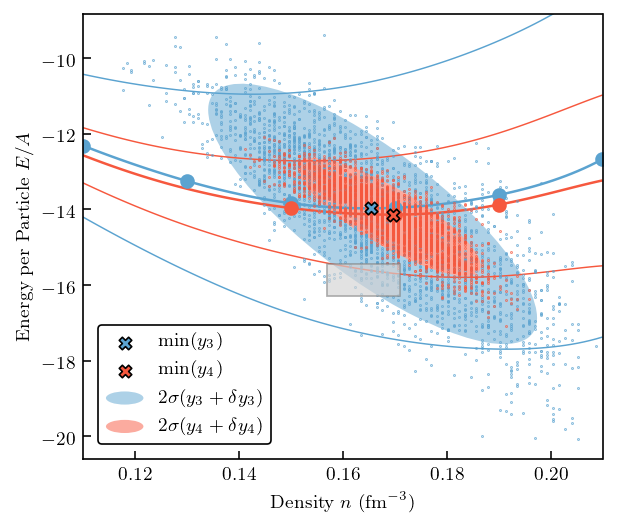

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.4))
np.random.seed(1)
analysis_s.plot_multi_saturation(
    breakdown=Lb, orders=[3,4], nugget=1e-6, X=Kf_s_dense,
    cond=sat_conditioned, n_samples=n_samples, ax=ax, savefig=True
);

RBF(length_scale=0.404) + WhiteKernel(noise_level=1e-05)
RBF(length_scale=0.404) + WhiteKernel(noise_level=1e-05)


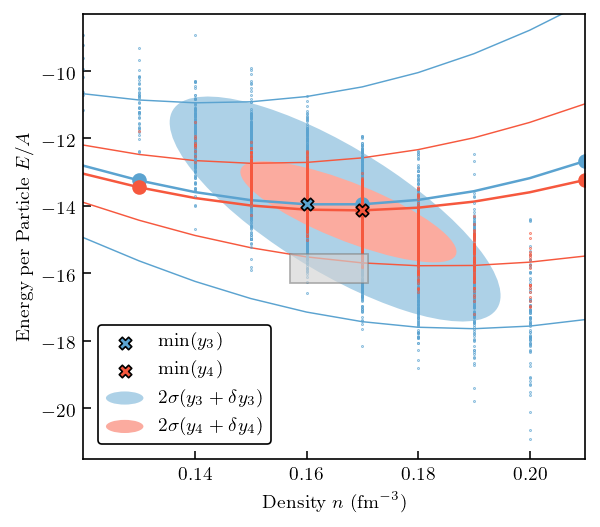

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.4))
np.random.seed(1)
analysis_s.plot_multi_saturation(
    breakdown=Lb, orders=[3,4], nugget=1e-7, X=Kf_s,
    cond=train,
    n_samples=n_samples, ax=ax, savefig=False
);

RBF(length_scale=0.482) + WhiteKernel(noise_level=1e-05)
RBF(length_scale=0.482) + WhiteKernel(noise_level=1e-05)


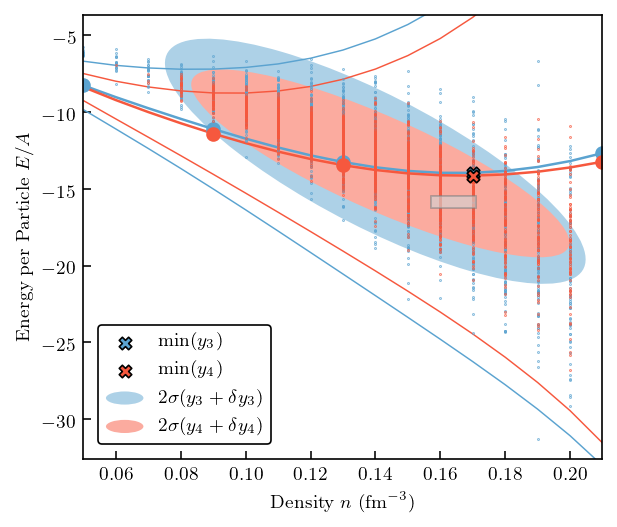

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.4))
np.random.seed(1)
analysis_s.plot_multi_saturation(
    breakdown=320., orders=[3,4], nugget=1e-5, X=Kf_s,
    cond=train,
    n_samples=n_samples, ax=ax, savefig=False
);

Using breakdown = 427.27272727272725 MeV
RBF(length_scale=0.449) + WhiteKernel(noise_level=1e-05)
RBF(length_scale=0.449) + WhiteKernel(noise_level=1e-05)


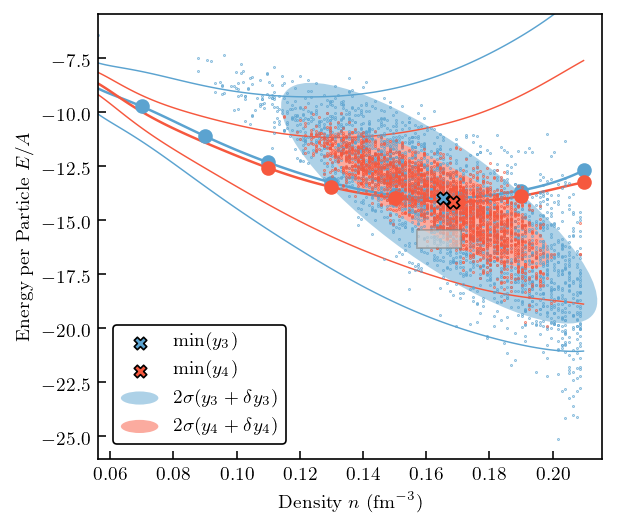

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.4))
np.random.seed(1)
analysis_s.plot_multi_saturation(
    orders=[3,4], nugget=1e-5, X=Kf_s_dense,
    cond=sat_conditioned, n_samples=n_samples, ax=ax, savefig=True
);

RBF(length_scale=0.371) + WhiteKernel(noise_level=1e-05)
cbar mean: 0.796860195724547


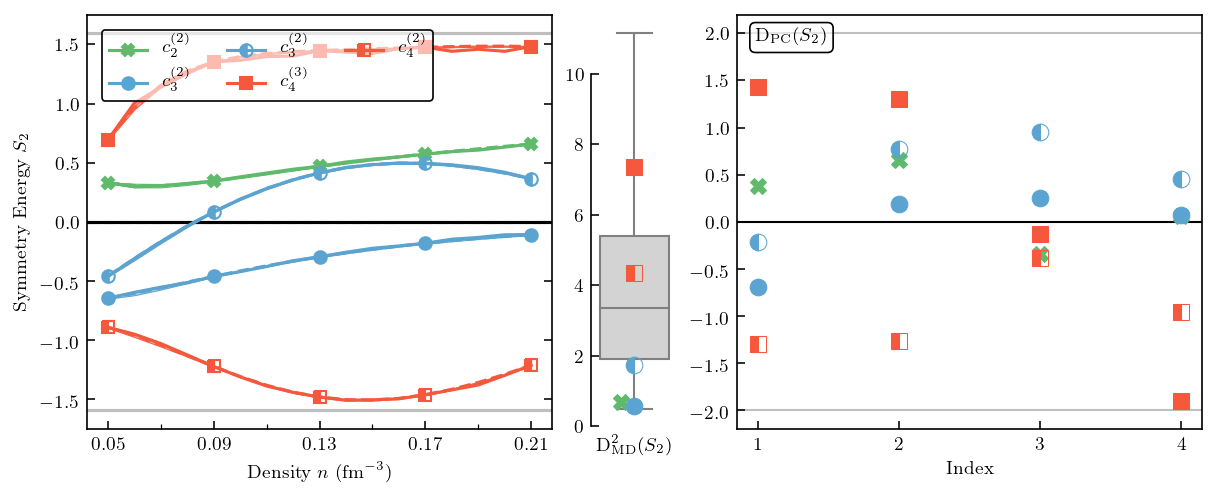

In [38]:
fig = analysis_d.plot_coeff_diagnostics(breakdown=Lb)

Using breakdown = 420.2020202020202 MeV
RBF(length_scale=0.378) + WhiteKernel(noise_level=1e-05)
cbar mean: 0.2428302176364857


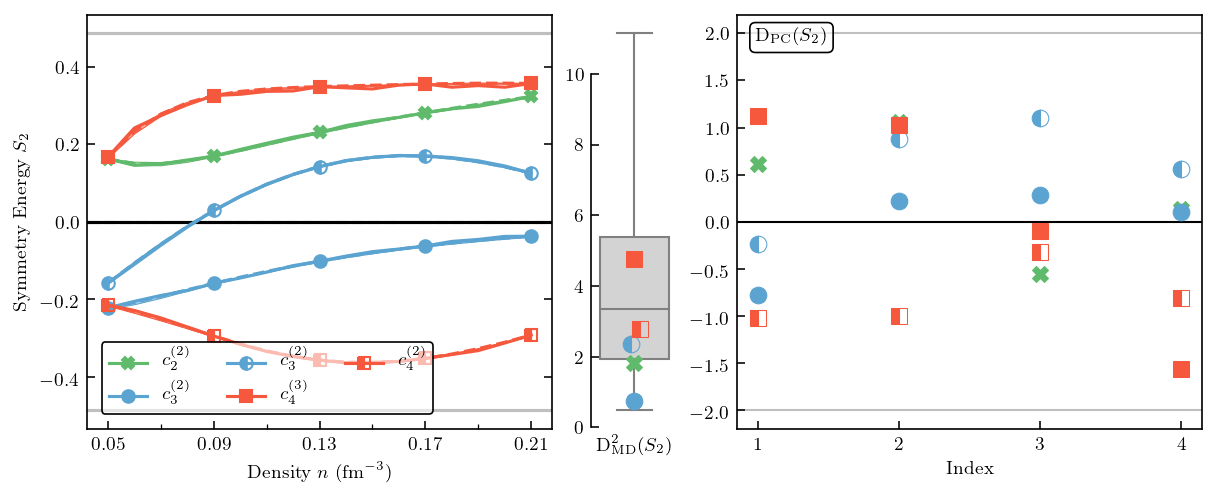

In [39]:
fig = analysis_d.plot_coeff_diagnostics(breakdown=None)

RBF(length_scale=0.374) + WhiteKernel(noise_level=1e-05)
cbar mean: 0.41921239771862107


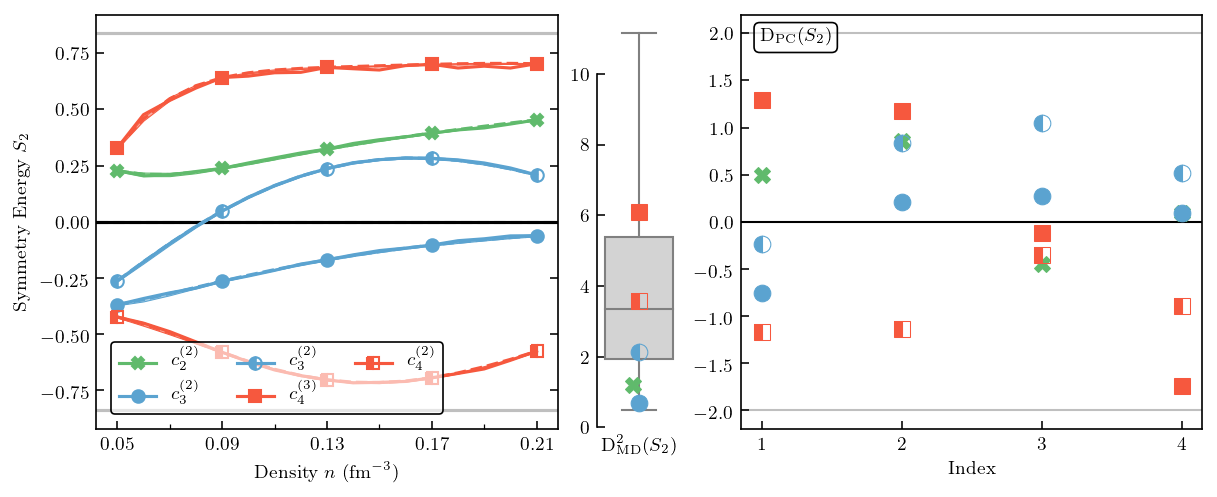

In [40]:
fig = analysis_d.plot_coeff_diagnostics(breakdown=lb_map)

In [41]:
# fig = analysis_d.plot_observables(breakdown=Lb, show_process=True)

In [42]:
# fig = analysis_d.plot_observables(breakdown=None, show_process=True)

In [43]:
# fig.savefig('test', metadata=dict(Keywords='??'))